# parse svg to get control points and length for each curve

In [1]:
from svg.path import parse_path
import xml.etree.ElementTree as ET
import numpy as np

ns = "{http://www.w3.org/2000/svg}"
tree = ET.parse("svgs/doll_dress_3.svg")
root = tree.getroot()

g = root.findall(ns + "g")[0]
paths = g.findall(ns  + "path")
path_objs = []

for p in paths:
    path_obj = parse_path(p.attrib["d"])
    path_objs.append(path_obj)


html_str_1 = '''
<!DOCTYPE html>
<html>
<body>

<svg height="800" width="1000">
<g transform="scale(4)">
'''

html_path_str = ""

# for p in paths:
#     html_path_str += "<path d=\"" + p.attrib["d"] + "\" />\n"
        
# [cps for curve1, cps for curve2, ...]
paths_cps = []
# [length of curve1, length of curve2, ...]
paths_lengths = []
# [[curve1_id, curve2_id, ..], [curve1_id, curve2_id, ..], ...] 
shape_curve_ids = []

c_id = 0
for p_obj in path_objs:
    path_cps = []
    path_lens = []
    curve_ids = []
    for i in range(len(p_obj)):
        curve = p_obj[i]
        p_name = type(curve).__name__
        d_str = ""
        if p_name == "CubicBezier":
            cpts = np.zeros([4, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.control1.real
            cpts[1][1] = -curve.control1.imag
            cpts[2][0] = curve.control2.real
            cpts[2][1] = -curve.control2.imag
            cpts[3][0] = curve.end.real
            cpts[3][1] = -curve.end.imag
            
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "C " + str(curve.control1.real) + " " + str(curve.control1.imag)
            d_str = d_str + ", " + str(curve.control2.real) + " " + str(curve.control2.imag)
            d_str = d_str + ", " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
        elif p_name == "Line" or p_name == "Close":
            if curve.length() < 0.0001:
                continue
                
            cpts = np.zeros([2, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.end.real
            cpts[1][1] = -curve.end.imag
        
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "L " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
            
        else:
            continue
            
        path_lens.append(curve.length())
        
        html_path_str += "<path id = \"" + str(c_id) + "\" d=\"" + d_str + "\" stroke=\"black\" fill=\"transparent\" />\n"
        c_id +=1
        
    shape_curve_ids.append(curve_ids)
    paths_cps.extend(path_cps)
    paths_lengths.extend(path_lens)
        
# label the paths
html_text_str = "<text font-size=\"4\">"

for i in range(len(paths_cps)):
    html_text_str = html_text_str + "<textPath href=\"#" + str(i) + "\" startOffset=\"40%\">" + str(i) + "</textPath>\n"
html_text_str += "</text>"

# end of html file
html_str_2 = '''
</g>
</svg>

</body>
</html>
'''
html_file = open("svg_display.html", "w")
html_file.write(html_str_1)
html_file.write(html_path_str)
html_file.write(html_text_str)
html_file.write(html_str_2)
html_file.close()


In [2]:
shape_ccw = [None] * len(shape_curve_ids)
for sid in range(len(shape_curve_ids)):
    cids = shape_curve_ids[sid]
    v1 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num = 0
    
    def getAngle(v1, v2):
        cross_p = np.cross(v1, v2)
        cos_theta = np.dot(v1, v2);
        if cross_p > 0:
            return cos_theta
        else:
            return -cos_theta
            
    for cid in range(1, len(cids)):
        v2 = paths_cps[cids[cid]][-1] - paths_cps[cids[cid]][0]
        wind_num += getAngle(v1, v2)
        v1 = v2;

    v2 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num += getAngle(v1, v2)
    
    if wind_num > 0:
        shape_ccw[sid] = True
    else:
        shape_ccw[sid] = False
print("shape_ccw: ", shape_ccw)

shape_ccw:  [False, False, False, True, True, True]


# specify pair of curves to match, if same orientation

In [3]:

path_pairs_no_orientation = [
    (8, 25), 
    (22, 5), 
    (13, 28),
    (14, 19),
    (30, 11),
    (31, 2),
    (23, 18),
    (1, 6),
    (27, 20),
    (3, 10),
    (12, 15),
    (32, 29)
]

path_pairs = []

In [4]:
def getShapeId(cid):
    global shape_curve_ids
    for sid in range(len(shape_curve_ids)):
        if cid in shape_curve_ids[sid]:
            return sid

for ppair in path_pairs_no_orientation:
    sid1 = getShapeId(ppair[0])
    sid2 = getShapeId(ppair[1])
    ccw1 = shape_ccw[sid1]
    ccw2 = shape_ccw[sid2]  
    path_pairs.append((ppair[0], ppair[1], False))

In [5]:

import math

path_lens = np.array(path_lens)

# at least have this many pts on one curve
min_curve_pts_num = 8

# resize the shape
size_multiplier = 1 / 20

# uv size relative to shape size
uv_multiplier = 1

# desired segment length
seg_len = np.amin(path_lens) / min_curve_pts_num

# get number of vertices for each curve
curve_vert_nums = [0] * len(paths_cps)

for pair in path_pairs:
    # use the maximum curve length of the pair of curves
    c1_len = paths_lengths[pair[0]]
    c2_len = paths_lengths[pair[1]]
    max_len = max(c1_len, c2_len)
    # ensure that each segment is less than seg_len
    c_vert_num = math.ceil( max_len / seg_len)
    # set vertices num for both curves
    curve_vert_nums[pair[0]] = c_vert_num
    curve_vert_nums[pair[1]] = c_vert_num

for cid in range(len(paths_cps)):
    # skip if already set
    if curve_vert_nums[cid] == 0:
        c_len = paths_lengths[cid]
        curve_vert_nums[cid] = math.ceil( c_len / seg_len)

bndry_verts = [None] * len(paths_cps)
err_thresh = 0.01
max_it = 20

def get_pair(c_id):
    global path_pairs
    for pair in path_pairs:
        if c_id == pair[0]:
            return pair[1]
        elif c_id == pair[1]:
            return pair[0]
    return -1

def getPtOnCurve(cps, t):
    return (1-t)**3 * cps[0] + 3*t*(1-t)**2 * cps[1] + 3*(1-t)*t**2 * cps[2] + t**3 * cps[3]

def getEquitDistantPtOnCurve(cps, pt_num, curve_len):
    N = 500
    prev_pt = cps[0]
    seg_lens = np.zeros(N)
    for i in range(1, N):
        t = i / N
        pt = getPtOnCurve(cps, t)
        seg_lens[i] = np.linalg.norm(pt - prev_pt)
        prev_pt = pt
    avg_seg_len = curve_len / pt_num
    bndry_pts = np.zeros([pt_num, 2])
    bndry_pts[0] = cps[0]

    last_seg = 0
    last_seg_part_len = 0
    ts = np.zeros(pt_num)

    for pt_id in range(1, pt_num):
        # find the segment up to which has avg_seg_len
        acc_len = last_seg_part_len
        for i in range(last_seg, N):
            if acc_len + seg_lens[i] < avg_seg_len:
                acc_len += seg_lens[i]
            else:
                # find the portion in segment
                last_seg_part_len = acc_len + seg_lens[i] - avg_seg_len
                last_seg = i + 1
                t = i / N - ( last_seg_part_len / seg_lens[i] ) / N
                ts[pt_id] = t
                bndry_pts[pt_id] = getPtOnCurve(cps, t)
#                 print("seg len = ", np.linalg.norm(bndry_pts[pt_id] - bndry_pts[pt_id-1]))
                break
    return bndry_pts

for curve_id in range(len(paths_cps)):
    curve_cps = paths_cps[curve_id]
    # number of verts on curve already calculated and stored in curve_vert_nums
    bndry_vert_num = curve_vert_nums[curve_id]
    # store curve vertices here
    curve_verts = np.zeros([bndry_vert_num, 2])

    # bezier curve
    if (len(curve_cps) == 4):
        curve_verts = getEquitDistantPtOnCurve(curve_cps, bndry_vert_num, paths_lengths[curve_id])
    # line
    elif (len(curve_cps) == 2):
        avg_seg_len = paths_lengths[curve_id] / bndry_vert_num
        d_t = 1 / bndry_vert_num
        t = 0
        dir_vec = (curve_cps[1] - curve_cps[0])
        for v_id in range(bndry_vert_num):
            pt_loc = curve_cps[0] + t * dir_vec
            curve_verts[v_id] = pt_loc
            t += d_t
    bndry_verts[curve_id] = curve_verts

for cid in range(len(bndry_verts)):
    for vid in range(len(bndry_verts[cid])):
        bndry_verts[cid][vid] *= size_multiplier

# how many vertices in each shape
shape_verts_num = [0] * len(path_objs)

for i in range(len(shape_curve_ids)):
    for curve_id in shape_curve_ids[i]:
        shape_verts_num[i] += len(bndry_verts[curve_id])



In [6]:
for sid in range(len(shape_curve_ids)):
    if not shape_ccw[sid]:
        for cid in shape_curve_ids[sid]:
            bndry_verts[cid] = bndry_verts[cid][::-1]
        
        for i in range(len(shape_curve_ids[sid])):
            cid = shape_curve_ids[sid][i]
            next_cid = shape_curve_ids[sid][(i+1)%len(shape_curve_ids[sid])]
            bndry_verts[cid] = np.insert(bndry_verts[cid], 0, bndry_verts[next_cid][-1], axis=0)
        
        for cid in shape_curve_ids[sid]:
            bndry_verts[cid] = np.delete(bndry_verts[cid], -1, axis=0)
            
        shape_curve_ids[sid] = shape_curve_ids[sid][::-1]

In [7]:
shape_curve_ids

[[5, 4, 3, 2, 1, 0],
 [11, 10, 9, 8, 7, 6],
 [16, 15, 14, 13, 12],
 [17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28],
 [29, 30, 31, 32, 33]]

# more segments for curves

In [8]:
# path_pair_segs = {
#     (13, 28):2,
#     (14, 19):2,
#     (30, 11):2,
#     (31, 2):2
# }

# cid_offset = len(bndry_verts)

# for pair in path_pair_segs:
#     print("pair: ", pair)
#     v_num = len(bndry_verts[pair[0]])
#     print("v_num: ", v_num)
#     end_vids = []
#     seg_num = path_pair_segs[pair]
#     for i in range(seg_num-1):
#         end_vids.append(int(v_num * (i+1) / seg_num) - 1)
#     end_vids.append(v_num-1)
    
#     p0_sid = getShapeId(pair[0])
#     p1_sid = getShapeId(pair[1])
    
#     p0_idx = shape_curve_ids[p0_sid].index(pair[0])
#     p1_idx = shape_curve_ids[p1_sid].index(pair[1])
    
#     bndry_verts_p0 = bndry_verts[pair[0]]
#     bndry_verts_p1 = bndry_verts[pair[1]][::-1]
    
#     new_bndry_0_verts = [None] * (seg_num - 1)
#     new_bndry_1_verts = [None] * (seg_num - 1)    
    
#     bndry_verts[pair[0]] = bndry_verts_p0[0:end_vids[0]+1]
#     bndry_verts[pair[1]] = bndry_verts_p1[0:end_vids[0]+1][::-1]
    
#     start_vid = end_vids[0]+1
#     for i in range(1, seg_num):
#         new_bndry_0_verts[i-1] = bndry_verts_p0[start_vid:end_vids[i]+1]
#         new_bndry_1_verts[i-1] = bndry_verts_p1[start_vid:end_vids[i]+1]
#         start_vid = end_vids[i]+1
        
#         bid_1 = cid_offset + i - 1
#         bid_2 = cid_offset + i + len(end_vids) - 2
        
#         shape_curve_ids[p0_sid].insert(p0_idx + i, bid_1)
#         shape_curve_ids[p1_sid].insert(p1_idx, bid_2)
        
#         path_pairs.append((bid_1, bid_2, False))
    
#     for i in range(0, len(new_bndry_0_verts)):
#         bndry_verts.append(new_bndry_0_verts[i])    
#     for i in range(0, len(new_bndry_1_verts)):
#         bndry_verts.append(new_bndry_1_verts[i][::-1])
    
#     cid_offset += (len(end_vids)-1) * 2
    
    
    
    

In [9]:
path_pairs

[(8, 25, False),
 (22, 5, False),
 (13, 28, False),
 (14, 19, False),
 (30, 11, False),
 (31, 2, False),
 (23, 18, False),
 (1, 6, False),
 (27, 20, False),
 (3, 10, False),
 (12, 15, False),
 (32, 29, False)]

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# plt.plot(uvs[:,0], uvs[:,1], 'o')

for sid in range(len(shape_curve_ids)):
    shape_vs = bndry_verts[shape_curve_ids[sid][0]]
    for i in range(1, len(shape_curve_ids[sid])):
        shape_vs = np.vstack((shape_vs, bndry_verts[shape_curve_ids[sid][i]]))
#     print("shape_vs: ", shape_vs)
    plt.plot(shape_vs[:,0], shape_vs[:,1])

In [11]:
path_pairs

[(8, 25, False),
 (22, 5, False),
 (13, 28, False),
 (14, 19, False),
 (30, 11, False),
 (31, 2, False),
 (23, 18, False),
 (1, 6, False),
 (27, 20, False),
 (3, 10, False),
 (12, 15, False),
 (32, 29, False)]

In [12]:
import get_polygons_2
import write_lib1
import subprocess
import numpy as np

polygon = get_polygons_2.Polygons(bndry_verts, shape_curve_ids, path_pairs)
write_lib1.write_pts_out(polygon, "./results/bndry_pts.txt")

polygon.applyMultiplier(uv_multiplier)
polygon.getPolyVerts()
polygon.getPolyVecs()
polygon.getAngles()
polygon.getCenters()
polygon.getPairAngleDiff()
polygon.writeOut()
polygon.writeVertsOut("poly_verts.txt")

len(self.poly_centers):  6
[ 8.31056425 -6.33272842]
[ 1.71349206 -6.3738838 ]
[ 2.91149991 -3.2517242 ]
[ 5.76967117 -6.35391992]
[ 3.94380294 -6.3860422 ]
[ 7.1304909 -3.4606565]
self.poly_centers:  [array([ 8.31056425, -6.33272842]), array([ 1.71349206, -6.3738838 ]), array([ 2.91149991, -3.2517242 ]), array([ 5.76967117, -6.35391992]), array([ 3.94380294, -6.3860422 ]), array([ 7.1304909, -3.4606565])]


In [13]:

subprocess.call(['C:\\gurobi902\\win64\\python37\\bin\\python.exe', 'opt_angles_6.py'])
polygon.readInRotation()
polygon.rotateShapes()
polygon.writeVertsOut("poly_verts_rot.txt")
polygon.getPolyVecs()
polygon.getAngles()
polygon.getPairAngleDiff()


self.shape_rotation:  [330.7403794649055, 355.3336187525853, 103.1212376848251, 0.0, 167.0799138617136, 42.30025155004362]
self.angles:  [[269.84597790287245, 359.3414502143424, 92.36951094323877, 97.20605778986508, 150.69003032000154, 200.6235220800089], [258.69006752597977, 266.5433803925624, 0.3794405306154396, 90.15697510796961, 136.12329933514735, 207.64596349581905], [359.6609740090719, 79.50852834878896, 155.43281912639176, 203.078216070567, 277.47733222760377], [159.376477919991, 209.30994697587846, 262.7939765090969, 267.63048905676123, 0.6585497856576029, 90.1540220971276], [152.35402895186812, 223.8767067236194, 269.8430248692741, 359.6205393926887, 93.45661960743757, 101.30993247402021], [82.52266987961245, 156.92178868285316, 204.56718087360827, 280.4914719862809, 0.33902233953918104]]
rot_angle:  330.7403794649055
disp:  [4.15554539 3.25396787]
rot_angle:  355.3336187525853
disp:  [0.52421882 0.11827138]
rot_angle:  103.1212376848251
disp:  [ 0.40561842 -6.82539178]
rot_a

In [14]:
polygon.writeOut2()
subprocess.call(['C:\\gurobi902\\win64\\python37\\bin\\python.exe', 'opt_verts_4.py'])

polygon.readInVerts()
polygon.intrpCurve()

bndry_c_verts_start = polygon.get_bndry_c_verts_start()

write_lib1.write_uvs_out(polygon, "./results/bndry_pts_uv.txt")
write_lib1.write_info_out(polygon, "./results/info.txt", seg_len, shape_verts_num, bndry_c_verts_start)

(0.38828231167514554,
 9.807375870214635,
 -9.042726048576599,
 -1.9569662499001454)

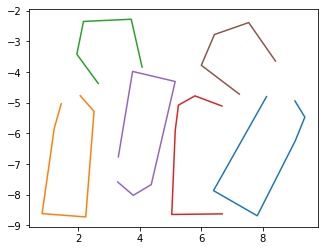

In [15]:
for sid in range(len(polygon.poly_verts)):

    poly_verts = np.array(polygon.poly_verts[sid])
    plt.plot(poly_verts[:,0], poly_verts[:,1])
#     print("polygon.poly_verts[sid]", np.array(polygon.poly_verts[sid]))
plt.axis('scaled')

(0.3990242920344793, 9.705223432842057, -9.16918020333816, -1.719107058904517)

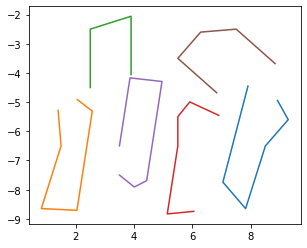

In [16]:
for i in range(len(polygon.shape_curve_ids)):
    poly_verts = []
    for cid in polygon.shape_curve_ids[i]:
        poly_verts.append(polygon.optimized_verts[cid])
    poly_verts = np.array(poly_verts)
    plt.plot(poly_verts[:,0], poly_verts[:,1])
    
plt.axis('scaled')

In [17]:
polygon.bndry_verts

[array([[ 9.05713295, -4.94215955],
        [ 8.93960726, -4.97719287],
        [ 8.81969472, -5.00270039],
        [ 8.69751771, -5.01176957],
        [ 8.57576587, -4.9985483 ],
        [ 8.45804883, -4.96451508],
        [ 8.34518428, -4.91661115],
        [ 8.23590752, -4.86094237]]), array([[ 9.37923525, -5.4692186 ],
        [ 9.31481479, -5.36380679],
        [ 9.25039433, -5.25839498],
        [ 9.18597387, -5.15298317],
        [ 9.12155341, -5.04757136]]), array([[ 9.06810179, -6.23723303],
        [ 8.97609424, -6.1426131 ],
        [ 8.91321918, -6.02707326],
        [ 8.90444971, -5.89650622],
        [ 8.95576574, -5.77565227],
        [ 9.04298292, -5.67671459],
        [ 9.14741543, -5.59582111],
        [ 9.2607452 , -5.52782131]]), array([[ 7.82764376, -8.68335581],
        [ 7.88215557, -8.56261728],
        [ 7.93550585, -8.44137009],
        [ 7.98761146, -8.31958091],
        [ 8.03838134, -8.1972268 ],
        [ 8.0877237 , -8.0742905 ],
        [ 8.13555625, -7.

In [18]:
# uvs = np.array(polygon.bndry_verts_uv)

In [19]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 15))

# plt.plot(uvs[:,0], uvs[:,1], 'o')

# # for cid in range(len(bndry_verts)):
# #     plt.plot(bndry_verts[cid][:,0], bndry_verts[cid][:,1], 'o')

# plt.axis('scaled')